In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Specify the model to be used
COCO and MPI are body pose estimation model. COCO has 18 points and MPI has 15 points as output.

HAND is hand keypoints estimation model. It has 22 points as output

Ensure that the model files are available in the folders.

In [2]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    

#### Let us load an image with multiple people and check what the model sees

In [3]:
image1 = cv2.imread("multiple.jpeg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]
threshold = 0.1

#### Load the network and pass the image through the network

In [38]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 400
inHeight = 400
inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
H = output.shape[2]
W = output.shape[3]
print(output.shape)

(1, 44, 50, 50)


#### Slice a probability map from the output for a specific keypoint and plot the heatmap ( after resizing ) on the image itself

(-0.5, 1279.5, 1071.5, -0.5)

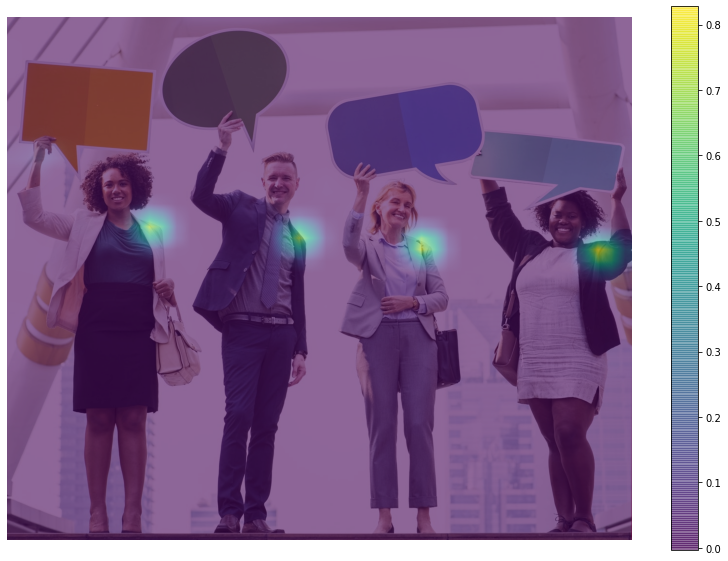

In [5]:
i = 5
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

#### Similarly plot the affinity map on the image

(-0.5, 1279.5, 1071.5, -0.5)

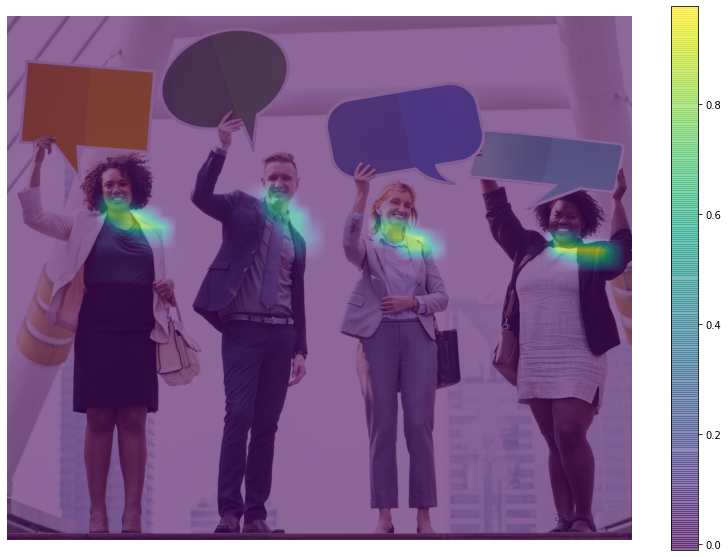

In [6]:
i = 24
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

#### Next, we find the keypoints for a image with only single person

In [27]:
frame = cv2.imread("tree.jpg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

black_canvas = np.zeros(shape = (frameWidth, frameHeight, 3))

In [14]:
frame.shape

(2048, 2048, 3)

In [20]:
black_canvas = np.zeros(shape = (2048, 2048, 3))

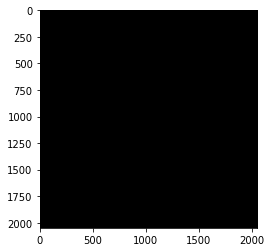

In [22]:
plt.imshow(black_canvas)

#### Pass it through the network

In [28]:
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
H = output.shape[2]
W = output.shape[3]

In [29]:
nPoints

15

#### gather the points and plot the keypoints and the skeleton figure

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


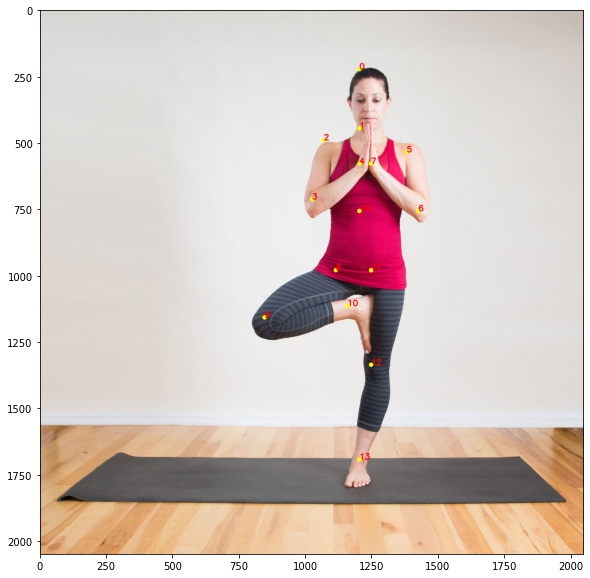

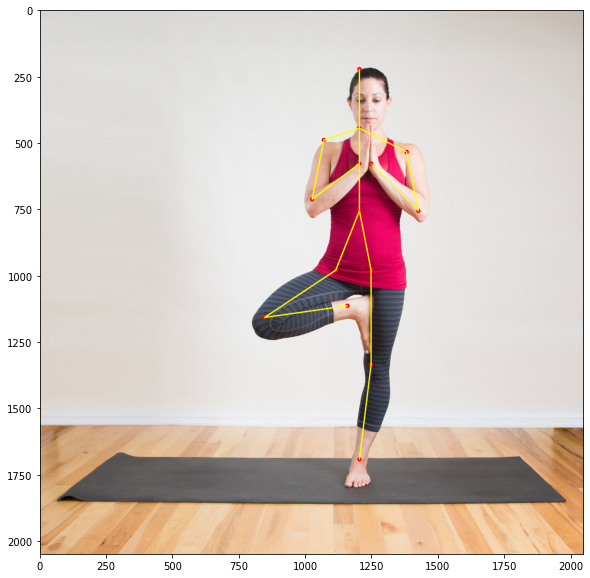

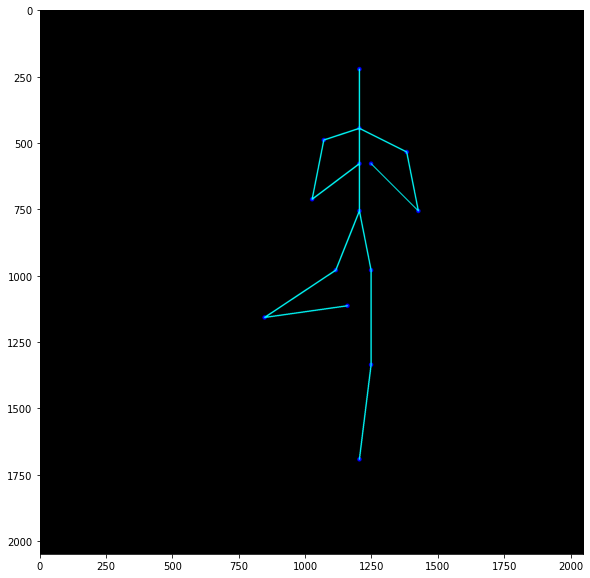

In [32]:
# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.circle(black_canvas, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)
        cv2.line(black_canvas, points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(black_canvas)

In [11]:
#Test cell
print(points)

[(369, 0), (369, 73), (447, 132), (485, 221), (485, 294), (310, 103), (272, 162), (155, 147), (408, 309), (447, 427), (447, 368), (349, 309), (349, 412), (369, 515), (388, 221)]


In [11]:
cap = cv2.VideoCapture("sample_video.mp4")
if (cap.isOpened()== False):
    print("Error opening video stream or file")
# Read until video is completed
frames = 0
while(cap.isOpened()):
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
    # Display the resulting frame
        cv2.imshow('Frame',frame)
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
  # Break the loop
    else:
        break
    frames += 1
    print(frames)
# When everything done, release the video capture object
cap.release()
# Closes all the frames
cv2.destroyAllWindows()


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235


In [8]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
nPoints = 15
POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
frame_counter = 0
inWidth = 368
inHeight = 368
threshold = 0.1


cap = cv2.VideoCapture("highlightreel1.mp4")
hasFrame, frame = cap.read()

vid_writer = cv2.VideoWriter('output1.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (frame.shape[1],frame.shape[0]))

while cv2.waitKey(1) < 0 and frame_counter <= 1000:
    t = time.time()
    hasFrame, frame = cap.read()
    frameCopy = np.copy(frame)
    if not hasFrame:
        cv2.waitKey()
        break

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()

    H = output.shape[2]
    W = output.shape[3]
    # Empty list to store the detected keypoints
    points = []

    for i in range(nPoints):
        # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        
        # Scale the point to fit on the original image
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H

        if prob > threshold : 
            cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)

            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
        else :
            points.append(None)

    # Draw Skeleton
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3, lineType=cv2.LINE_AA)
            cv2.circle(frame, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.circle(frame, points[partB], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

    cv2.putText(frame, "time taken = {:.2f} sec".format(time.time() - t), (50, 50), cv2.FONT_HERSHEY_COMPLEX, .8, (255, 50, 0), 2, lineType=cv2.LINE_AA)
    # cv2.putText(frame, "OpenPose using OpenCV", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 50, 0), 2, lineType=cv2.LINE_AA)
    # cv2.imshow('Output-Keypoints', frameCopy)

    vid_writer.write(frame)
    frame_counter = frame_counter+1
    print(frame_counter)
vid_writer.release()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [7]:
cap = cv2.VideoCapture("output1.mp4")
if (cap.isOpened()== False):
    print("Error opening video stream or file")
# Read until video is completed
frames = 0
while(cap.isOpened()):
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
    # Display the resulting frame
        cv2.imshow('Frame',frame)
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
  # Break the loop
    else:
        break
    frames += 1
    print(frames)
# When everything done, release the video capture object
cap.release()
# Closes all the frames
cv2.destroyAllWindows()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135


In [36]:
frame = cv2.imread('single.jpeg')

In [37]:
frame.shape

(960, 640, 3)